# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

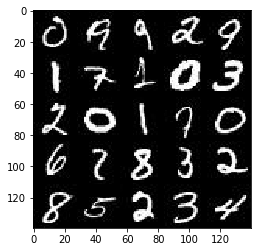

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

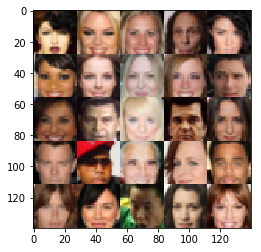

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate_in = tf.placeholder(tf.float32, None, name='learning_rate')
    return input_real, input_z, learning_rate_in


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    dropout = 0.8
    
    # kernel initializer
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kernel_init, padding='same')
        layer1 = tf.nn.dropout(layer1, dropout)
        layer1 = tf.maximum(alpha * layer1, layer1)  
        
        # 14x14x64
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, kernel_initializer=kernel_init, padding='same')
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.nn.dropout(layer2, dropout)
        layer2 = tf.maximum(alpha * layer2, layer2)
        
        # 7x7x128   
        
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, kernel_initializer=kernel_init, padding='same')
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.nn.dropout(layer3, dropout)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
        # 4x4x256 

        # Flatten
        flat = tf.reshape(layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)        
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2 
    dropout = 0.8
    
    # kernel initializer
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope("generator", reuse = not is_train):
        # First fully connected layer
        layer1 = tf.layers.dense(z, 7*7*256)        
        layer1 = tf.reshape(layer1, (-1, 7, 7, 256))
        layer1 = tf.layers.dropout(layer1, 0.5, training = is_train)
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha * layer1, layer1)           
        
        # 7x7x256
        
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, strides=2,  kernel_initializer=kernel_init, padding='same')
        # 7x7x128
        layer2 = tf.layers.dropout(layer2, 0.5, training = is_train)
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha * layer2, layer2)
        

        
        layer3 = tf.layers.conv2d_transpose(layer2, 64, 5, strides=2,  kernel_initializer=kernel_init, padding='same')
        # 14x14x64
        layer3 = tf.layers.dropout(layer3, 0.5, training = is_train)
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha * layer3, layer3)
        
          
        # Output layer
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim , 5, strides=1,  kernel_initializer=kernel_init, padding='same')
        
        # 28x28xout_channel_dim    
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(gen_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_logits_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_logits_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_variables = tf.trainable_variables()
    dis_variables = [var for var in train_variables if var.name.startswith('discriminator')]
    gen_variables = [var for var in train_variables if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_variables)
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_variables)
    
        return dis_train_ops, gen_train_ops


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learning_rate_in = model_inputs(image_width, image_height, image_channels, z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    dis_ops, gen_ops = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    print_every = 10
    show_every = 100
    steps = 0
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(dis_ops, feed_dict={ input_real: batch_images, input_z: batch_z, learning_rate_in: learning_rate })
                _ = sess.run(gen_ops, feed_dict={ input_z: batch_z, learning_rate_in: learning_rate })
                
                if steps % print_every == 0:
                    dis_loss_train = dis_loss.eval({
                        input_z: batch_z,
                        input_real: batch_images
                    })
                    gen_loss_train = gen_loss.eval({
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Generator Loss: {:.4f}".format(gen_loss_train),
                         "Discriminator Loss: {:.4f}...".format(dis_loss_train))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Generator Loss: 3.1455 Discriminator Loss: 0.5089...
Epoch 1/2... Generator Loss: 4.5319 Discriminator Loss: 1.1340...
Epoch 1/2... Generator Loss: 2.4631 Discriminator Loss: 0.7957...
Epoch 1/2... Generator Loss: 1.8709 Discriminator Loss: 0.8285...
Epoch 1/2... Generator Loss: 0.7832 Discriminator Loss: 1.4174...
Epoch 1/2... Generator Loss: 1.5474 Discriminator Loss: 0.8088...
Epoch 1/2... Generator Loss: 2.9183 Discriminator Loss: 0.7529...
Epoch 1/2... Generator Loss: 2.0260 Discriminator Loss: 1.0555...
Epoch 1/2... Generator Loss: 2.1950 Discriminator Loss: 0.9192...
Epoch 1/2... Generator Loss: 2.7467 Discriminator Loss: 1.0884...


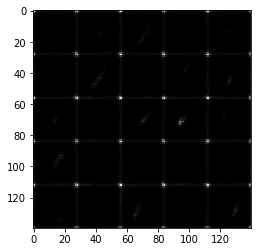

Epoch 1/2... Generator Loss: 1.5791 Discriminator Loss: 0.8971...
Epoch 1/2... Generator Loss: 2.0610 Discriminator Loss: 0.7658...
Epoch 1/2... Generator Loss: 1.2021 Discriminator Loss: 1.0045...
Epoch 1/2... Generator Loss: 1.9083 Discriminator Loss: 0.7343...
Epoch 1/2... Generator Loss: 2.0161 Discriminator Loss: 0.8844...
Epoch 1/2... Generator Loss: 1.6266 Discriminator Loss: 0.9420...
Epoch 1/2... Generator Loss: 0.7180 Discriminator Loss: 1.2530...
Epoch 1/2... Generator Loss: 2.6633 Discriminator Loss: 0.9202...
Epoch 1/2... Generator Loss: 0.9495 Discriminator Loss: 1.2017...
Epoch 1/2... Generator Loss: 2.5669 Discriminator Loss: 0.8864...


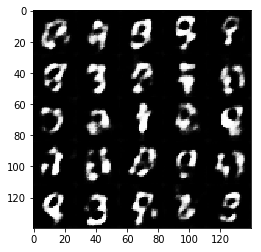

Epoch 1/2... Generator Loss: 2.6431 Discriminator Loss: 0.7130...
Epoch 1/2... Generator Loss: 1.3499 Discriminator Loss: 1.0480...
Epoch 1/2... Generator Loss: 1.1506 Discriminator Loss: 1.0572...
Epoch 1/2... Generator Loss: 2.0011 Discriminator Loss: 1.0945...
Epoch 1/2... Generator Loss: 1.4071 Discriminator Loss: 0.9337...
Epoch 1/2... Generator Loss: 2.4709 Discriminator Loss: 0.9984...
Epoch 1/2... Generator Loss: 2.0802 Discriminator Loss: 0.6907...
Epoch 1/2... Generator Loss: 1.9405 Discriminator Loss: 1.1333...
Epoch 1/2... Generator Loss: 2.4445 Discriminator Loss: 0.7519...
Epoch 1/2... Generator Loss: 2.0222 Discriminator Loss: 0.6623...


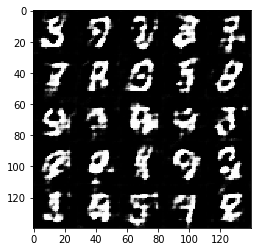

Epoch 1/2... Generator Loss: 2.6054 Discriminator Loss: 0.7939...
Epoch 1/2... Generator Loss: 2.1720 Discriminator Loss: 0.5967...
Epoch 1/2... Generator Loss: 2.1670 Discriminator Loss: 0.8345...
Epoch 1/2... Generator Loss: 2.5884 Discriminator Loss: 1.0001...
Epoch 1/2... Generator Loss: 3.1968 Discriminator Loss: 0.6996...
Epoch 1/2... Generator Loss: 2.4233 Discriminator Loss: 0.6976...
Epoch 1/2... Generator Loss: 1.3048 Discriminator Loss: 0.9726...
Epoch 1/2... Generator Loss: 3.1315 Discriminator Loss: 0.6654...
Epoch 1/2... Generator Loss: 2.9501 Discriminator Loss: 0.7943...
Epoch 1/2... Generator Loss: 1.5802 Discriminator Loss: 0.8033...


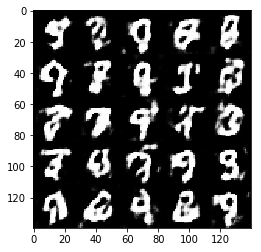

Epoch 1/2... Generator Loss: 2.4081 Discriminator Loss: 0.6062...
Epoch 1/2... Generator Loss: 3.0928 Discriminator Loss: 0.5998...
Epoch 1/2... Generator Loss: 3.6161 Discriminator Loss: 1.0080...
Epoch 1/2... Generator Loss: 2.0630 Discriminator Loss: 0.7676...
Epoch 1/2... Generator Loss: 1.7967 Discriminator Loss: 0.6314...
Epoch 1/2... Generator Loss: 3.5226 Discriminator Loss: 0.7867...
Epoch 1/2... Generator Loss: 2.9241 Discriminator Loss: 0.5916...
Epoch 1/2... Generator Loss: 3.5783 Discriminator Loss: 0.6801...
Epoch 1/2... Generator Loss: 2.3649 Discriminator Loss: 0.6448...
Epoch 1/2... Generator Loss: 1.1689 Discriminator Loss: 1.1485...


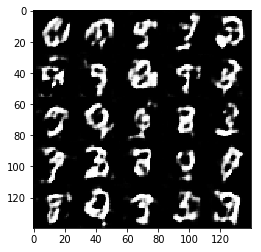

Epoch 1/2... Generator Loss: 1.9556 Discriminator Loss: 0.6421...
Epoch 1/2... Generator Loss: 3.5187 Discriminator Loss: 0.6188...
Epoch 1/2... Generator Loss: 1.2633 Discriminator Loss: 1.2149...
Epoch 1/2... Generator Loss: 2.2813 Discriminator Loss: 0.6075...
Epoch 1/2... Generator Loss: 2.5138 Discriminator Loss: 0.7538...
Epoch 1/2... Generator Loss: 2.2974 Discriminator Loss: 0.6869...
Epoch 1/2... Generator Loss: 2.6864 Discriminator Loss: 0.6599...
Epoch 1/2... Generator Loss: 3.6281 Discriminator Loss: 0.7617...
Epoch 1/2... Generator Loss: 1.6758 Discriminator Loss: 0.7907...
Epoch 1/2... Generator Loss: 3.0846 Discriminator Loss: 0.7252...


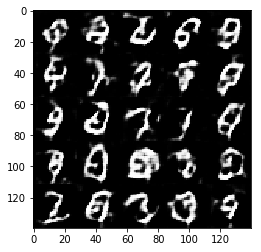

Epoch 1/2... Generator Loss: 2.2619 Discriminator Loss: 0.6515...
Epoch 1/2... Generator Loss: 2.1811 Discriminator Loss: 0.6361...
Epoch 1/2... Generator Loss: 3.1441 Discriminator Loss: 0.6532...
Epoch 1/2... Generator Loss: 2.3595 Discriminator Loss: 0.6621...
Epoch 1/2... Generator Loss: 1.9719 Discriminator Loss: 0.7745...
Epoch 1/2... Generator Loss: 2.6093 Discriminator Loss: 0.7514...
Epoch 1/2... Generator Loss: 1.9210 Discriminator Loss: 0.8212...
Epoch 1/2... Generator Loss: 1.1370 Discriminator Loss: 0.9304...
Epoch 1/2... Generator Loss: 1.7113 Discriminator Loss: 0.7914...
Epoch 1/2... Generator Loss: 2.3140 Discriminator Loss: 0.7790...


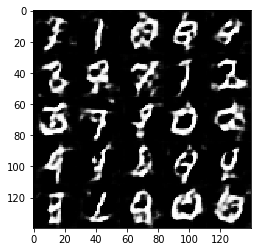

Epoch 1/2... Generator Loss: 2.3862 Discriminator Loss: 0.6947...
Epoch 1/2... Generator Loss: 1.9955 Discriminator Loss: 0.7367...
Epoch 1/2... Generator Loss: 1.9803 Discriminator Loss: 0.7588...
Epoch 1/2... Generator Loss: 2.2292 Discriminator Loss: 0.7532...
Epoch 1/2... Generator Loss: 1.0236 Discriminator Loss: 1.0410...
Epoch 1/2... Generator Loss: 1.7638 Discriminator Loss: 0.8166...
Epoch 1/2... Generator Loss: 2.4231 Discriminator Loss: 0.6417...
Epoch 1/2... Generator Loss: 2.0045 Discriminator Loss: 0.7151...
Epoch 1/2... Generator Loss: 1.4577 Discriminator Loss: 0.8397...
Epoch 1/2... Generator Loss: 1.5101 Discriminator Loss: 0.9421...


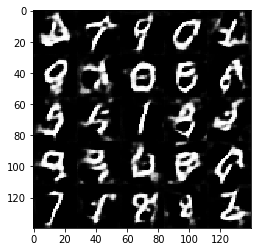

Epoch 1/2... Generator Loss: 2.2335 Discriminator Loss: 0.7428...
Epoch 1/2... Generator Loss: 2.5453 Discriminator Loss: 0.8542...
Epoch 1/2... Generator Loss: 1.9472 Discriminator Loss: 0.7185...
Epoch 1/2... Generator Loss: 2.0430 Discriminator Loss: 0.8897...
Epoch 1/2... Generator Loss: 1.2784 Discriminator Loss: 0.9164...
Epoch 1/2... Generator Loss: 1.8537 Discriminator Loss: 0.6467...
Epoch 1/2... Generator Loss: 1.8552 Discriminator Loss: 0.8796...
Epoch 1/2... Generator Loss: 1.7779 Discriminator Loss: 0.8108...
Epoch 1/2... Generator Loss: 1.6219 Discriminator Loss: 0.7738...
Epoch 1/2... Generator Loss: 1.4444 Discriminator Loss: 0.7760...


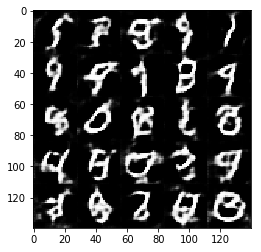

Epoch 1/2... Generator Loss: 1.1882 Discriminator Loss: 0.8819...
Epoch 1/2... Generator Loss: 3.2327 Discriminator Loss: 0.9825...
Epoch 1/2... Generator Loss: 3.2955 Discriminator Loss: 1.2920...
Epoch 2/2... Generator Loss: 2.4565 Discriminator Loss: 0.7449...
Epoch 2/2... Generator Loss: 2.3326 Discriminator Loss: 0.7570...
Epoch 2/2... Generator Loss: 1.7981 Discriminator Loss: 0.6361...
Epoch 2/2... Generator Loss: 1.4945 Discriminator Loss: 0.7943...
Epoch 2/2... Generator Loss: 1.0954 Discriminator Loss: 0.9295...
Epoch 2/2... Generator Loss: 1.9680 Discriminator Loss: 0.8061...
Epoch 2/2... Generator Loss: 2.1595 Discriminator Loss: 0.7847...


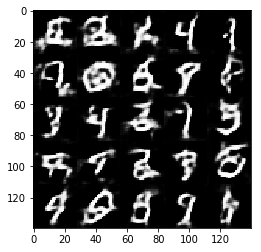

Epoch 2/2... Generator Loss: 2.2008 Discriminator Loss: 0.6072...
Epoch 2/2... Generator Loss: 1.9320 Discriminator Loss: 0.6975...
Epoch 2/2... Generator Loss: 1.0904 Discriminator Loss: 0.9879...
Epoch 2/2... Generator Loss: 2.7255 Discriminator Loss: 0.8562...
Epoch 2/2... Generator Loss: 1.4172 Discriminator Loss: 0.8396...
Epoch 2/2... Generator Loss: 2.2453 Discriminator Loss: 0.6651...
Epoch 2/2... Generator Loss: 0.9710 Discriminator Loss: 1.1749...
Epoch 2/2... Generator Loss: 1.6988 Discriminator Loss: 0.7549...
Epoch 2/2... Generator Loss: 2.3787 Discriminator Loss: 0.6915...
Epoch 2/2... Generator Loss: 2.2577 Discriminator Loss: 0.7144...


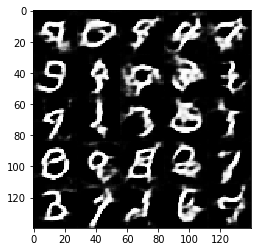

Epoch 2/2... Generator Loss: 2.0587 Discriminator Loss: 0.7036...
Epoch 2/2... Generator Loss: 3.1308 Discriminator Loss: 1.0305...
Epoch 2/2... Generator Loss: 1.9869 Discriminator Loss: 0.7488...
Epoch 2/2... Generator Loss: 1.0052 Discriminator Loss: 1.1562...
Epoch 2/2... Generator Loss: 2.8840 Discriminator Loss: 0.8074...
Epoch 2/2... Generator Loss: 1.3804 Discriminator Loss: 0.7005...
Epoch 2/2... Generator Loss: 2.0081 Discriminator Loss: 0.7028...
Epoch 2/2... Generator Loss: 2.3818 Discriminator Loss: 0.7736...
Epoch 2/2... Generator Loss: 1.7248 Discriminator Loss: 0.7169...
Epoch 2/2... Generator Loss: 2.8648 Discriminator Loss: 1.1107...


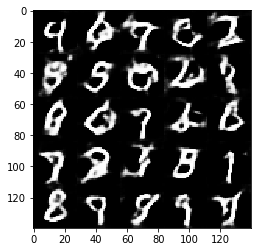

Epoch 2/2... Generator Loss: 1.4066 Discriminator Loss: 0.9432...
Epoch 2/2... Generator Loss: 2.5511 Discriminator Loss: 0.8699...
Epoch 2/2... Generator Loss: 1.7874 Discriminator Loss: 0.8765...
Epoch 2/2... Generator Loss: 2.1441 Discriminator Loss: 0.7253...
Epoch 2/2... Generator Loss: 1.8978 Discriminator Loss: 0.6531...
Epoch 2/2... Generator Loss: 2.3394 Discriminator Loss: 0.7508...
Epoch 2/2... Generator Loss: 2.9252 Discriminator Loss: 0.7992...
Epoch 2/2... Generator Loss: 1.9804 Discriminator Loss: 0.7313...
Epoch 2/2... Generator Loss: 2.2615 Discriminator Loss: 0.6361...
Epoch 2/2... Generator Loss: 2.6737 Discriminator Loss: 0.7437...


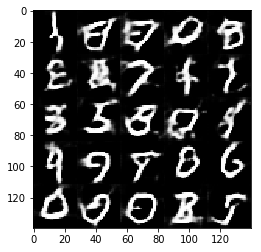

Epoch 2/2... Generator Loss: 2.0605 Discriminator Loss: 0.8407...
Epoch 2/2... Generator Loss: 2.1116 Discriminator Loss: 0.7572...
Epoch 2/2... Generator Loss: 3.0545 Discriminator Loss: 0.9863...
Epoch 2/2... Generator Loss: 1.7083 Discriminator Loss: 0.7594...
Epoch 2/2... Generator Loss: 1.6219 Discriminator Loss: 0.7808...
Epoch 2/2... Generator Loss: 2.6183 Discriminator Loss: 0.8538...
Epoch 2/2... Generator Loss: 3.4672 Discriminator Loss: 0.9568...
Epoch 2/2... Generator Loss: 1.4711 Discriminator Loss: 0.8891...
Epoch 2/2... Generator Loss: 2.9324 Discriminator Loss: 0.9349...
Epoch 2/2... Generator Loss: 3.3826 Discriminator Loss: 1.1014...


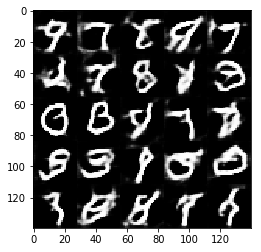

Epoch 2/2... Generator Loss: 1.6214 Discriminator Loss: 0.7996...
Epoch 2/2... Generator Loss: 2.6838 Discriminator Loss: 0.8385...
Epoch 2/2... Generator Loss: 1.9443 Discriminator Loss: 0.7720...
Epoch 2/2... Generator Loss: 3.0752 Discriminator Loss: 0.9183...
Epoch 2/2... Generator Loss: 1.6783 Discriminator Loss: 0.6823...
Epoch 2/2... Generator Loss: 2.4122 Discriminator Loss: 0.7343...
Epoch 2/2... Generator Loss: 2.2614 Discriminator Loss: 0.6997...
Epoch 2/2... Generator Loss: 2.0176 Discriminator Loss: 0.7745...
Epoch 2/2... Generator Loss: 2.3715 Discriminator Loss: 0.7031...
Epoch 2/2... Generator Loss: 1.8326 Discriminator Loss: 0.7354...


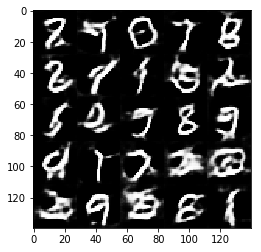

Epoch 2/2... Generator Loss: 1.4364 Discriminator Loss: 0.9114...
Epoch 2/2... Generator Loss: 2.1056 Discriminator Loss: 0.7367...
Epoch 2/2... Generator Loss: 2.6163 Discriminator Loss: 0.7649...
Epoch 2/2... Generator Loss: 2.5359 Discriminator Loss: 0.8153...
Epoch 2/2... Generator Loss: 2.1265 Discriminator Loss: 0.6357...
Epoch 2/2... Generator Loss: 1.4909 Discriminator Loss: 0.7684...
Epoch 2/2... Generator Loss: 2.4709 Discriminator Loss: 0.7338...
Epoch 2/2... Generator Loss: 2.7478 Discriminator Loss: 0.8267...
Epoch 2/2... Generator Loss: 2.0280 Discriminator Loss: 0.7885...
Epoch 2/2... Generator Loss: 2.1369 Discriminator Loss: 0.6939...


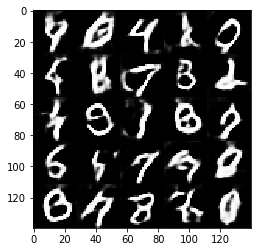

Epoch 2/2... Generator Loss: 1.6598 Discriminator Loss: 0.7435...
Epoch 2/2... Generator Loss: 1.7539 Discriminator Loss: 0.7441...
Epoch 2/2... Generator Loss: 2.1207 Discriminator Loss: 0.6839...
Epoch 2/2... Generator Loss: 1.9919 Discriminator Loss: 0.7361...
Epoch 2/2... Generator Loss: 2.0613 Discriminator Loss: 0.7108...
Epoch 2/2... Generator Loss: 3.1427 Discriminator Loss: 0.7931...
Epoch 2/2... Generator Loss: 2.7577 Discriminator Loss: 0.7066...
Epoch 2/2... Generator Loss: 2.4537 Discriminator Loss: 0.6816...
Epoch 2/2... Generator Loss: 1.4233 Discriminator Loss: 0.7947...
Epoch 2/2... Generator Loss: 1.5774 Discriminator Loss: 0.7642...


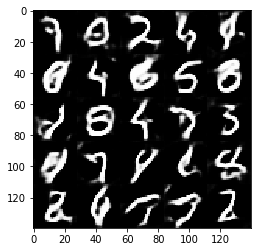

Epoch 2/2... Generator Loss: 2.1430 Discriminator Loss: 0.7284...
Epoch 2/2... Generator Loss: 1.7683 Discriminator Loss: 0.6759...
Epoch 2/2... Generator Loss: 2.2238 Discriminator Loss: 0.7115...
Epoch 2/2... Generator Loss: 3.8772 Discriminator Loss: 1.5815...
Epoch 2/2... Generator Loss: 2.6373 Discriminator Loss: 0.6439...
Epoch 2/2... Generator Loss: 1.9845 Discriminator Loss: 0.7635...
Epoch 2/2... Generator Loss: 1.2390 Discriminator Loss: 0.9350...
Epoch 2/2... Generator Loss: 2.2046 Discriminator Loss: 0.6311...
Epoch 2/2... Generator Loss: 1.8796 Discriminator Loss: 0.6133...
Epoch 2/2... Generator Loss: 2.4394 Discriminator Loss: 0.6045...


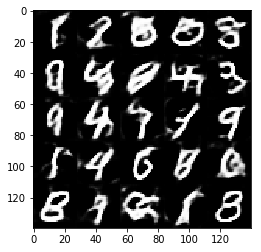

Epoch 2/2... Generator Loss: 2.3818 Discriminator Loss: 0.6790...
Epoch 2/2... Generator Loss: 1.4895 Discriminator Loss: 0.7464...
Epoch 2/2... Generator Loss: 3.0425 Discriminator Loss: 0.7441...
Epoch 2/2... Generator Loss: 2.4599 Discriminator Loss: 0.7993...
Epoch 2/2... Generator Loss: 2.0011 Discriminator Loss: 0.6900...
Epoch 2/2... Generator Loss: 3.1272 Discriminator Loss: 0.8238...
Epoch 2/2... Generator Loss: 1.1828 Discriminator Loss: 0.7493...


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Generator Loss: 3.5254 Discriminator Loss: 0.4706...
Epoch 1/1... Generator Loss: 3.8607 Discriminator Loss: 0.4608...
Epoch 1/1... Generator Loss: 3.9228 Discriminator Loss: 0.3989...
Epoch 1/1... Generator Loss: 4.1173 Discriminator Loss: 0.4035...
Epoch 1/1... Generator Loss: 4.3864 Discriminator Loss: 0.4021...
Epoch 1/1... Generator Loss: 4.2947 Discriminator Loss: 0.3962...
Epoch 1/1... Generator Loss: 3.0262 Discriminator Loss: 0.5079...
Epoch 1/1... Generator Loss: 3.7875 Discriminator Loss: 0.5102...
Epoch 1/1... Generator Loss: 3.9591 Discriminator Loss: 0.4230...
Epoch 1/1... Generator Loss: 4.8815 Discriminator Loss: 0.5119...


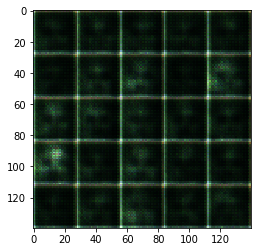

Epoch 1/1... Generator Loss: 3.4315 Discriminator Loss: 0.4585...
Epoch 1/1... Generator Loss: 4.6906 Discriminator Loss: 0.5011...
Epoch 1/1... Generator Loss: 2.9461 Discriminator Loss: 0.5025...
Epoch 1/1... Generator Loss: 4.6123 Discriminator Loss: 0.4166...
Epoch 1/1... Generator Loss: 4.8862 Discriminator Loss: 0.4637...
Epoch 1/1... Generator Loss: 4.5642 Discriminator Loss: 0.4748...
Epoch 1/1... Generator Loss: 4.5651 Discriminator Loss: 0.4380...
Epoch 1/1... Generator Loss: 3.7050 Discriminator Loss: 0.4599...
Epoch 1/1... Generator Loss: 4.9257 Discriminator Loss: 0.4592...
Epoch 1/1... Generator Loss: 4.4451 Discriminator Loss: 0.3913...


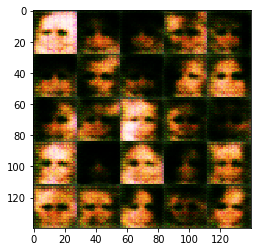

Epoch 1/1... Generator Loss: 3.3175 Discriminator Loss: 0.4465...
Epoch 1/1... Generator Loss: 4.4075 Discriminator Loss: 0.4148...
Epoch 1/1... Generator Loss: 3.7477 Discriminator Loss: 0.4380...
Epoch 1/1... Generator Loss: 2.3370 Discriminator Loss: 0.4909...
Epoch 1/1... Generator Loss: 4.6323 Discriminator Loss: 0.3999...
Epoch 1/1... Generator Loss: 3.2362 Discriminator Loss: 0.4586...
Epoch 1/1... Generator Loss: 5.3343 Discriminator Loss: 0.3723...
Epoch 1/1... Generator Loss: 4.2073 Discriminator Loss: 0.4141...
Epoch 1/1... Generator Loss: 5.7992 Discriminator Loss: 0.4230...
Epoch 1/1... Generator Loss: 3.2444 Discriminator Loss: 0.5294...


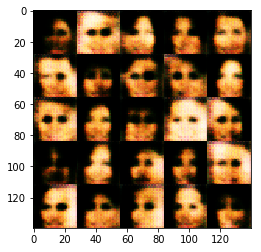

Epoch 1/1... Generator Loss: 3.9154 Discriminator Loss: 0.4445...
Epoch 1/1... Generator Loss: 4.5872 Discriminator Loss: 0.3783...
Epoch 1/1... Generator Loss: 2.7966 Discriminator Loss: 0.4781...
Epoch 1/1... Generator Loss: 4.7737 Discriminator Loss: 0.3887...
Epoch 1/1... Generator Loss: 3.2522 Discriminator Loss: 0.4473...
Epoch 1/1... Generator Loss: 3.1818 Discriminator Loss: 0.4766...
Epoch 1/1... Generator Loss: 5.0816 Discriminator Loss: 0.4296...
Epoch 1/1... Generator Loss: 1.4659 Discriminator Loss: 0.9776...
Epoch 1/1... Generator Loss: 3.8828 Discriminator Loss: 0.4630...
Epoch 1/1... Generator Loss: 3.6194 Discriminator Loss: 0.4472...


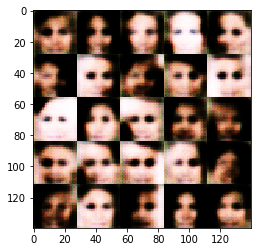

Epoch 1/1... Generator Loss: 4.8178 Discriminator Loss: 0.4125...
Epoch 1/1... Generator Loss: 3.0348 Discriminator Loss: 0.4535...
Epoch 1/1... Generator Loss: 2.7737 Discriminator Loss: 0.5234...
Epoch 1/1... Generator Loss: 4.4017 Discriminator Loss: 0.3969...
Epoch 1/1... Generator Loss: 2.9568 Discriminator Loss: 0.4567...
Epoch 1/1... Generator Loss: 2.2739 Discriminator Loss: 0.5316...
Epoch 1/1... Generator Loss: 4.3285 Discriminator Loss: 0.3945...
Epoch 1/1... Generator Loss: 3.4916 Discriminator Loss: 0.4649...
Epoch 1/1... Generator Loss: 4.3187 Discriminator Loss: 0.4565...
Epoch 1/1... Generator Loss: 1.2131 Discriminator Loss: 0.8234...


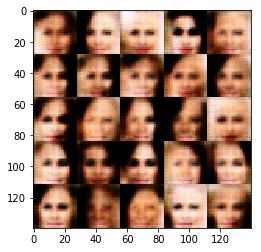

Epoch 1/1... Generator Loss: 2.5535 Discriminator Loss: 0.5732...
Epoch 1/1... Generator Loss: 4.0295 Discriminator Loss: 0.4271...
Epoch 1/1... Generator Loss: 0.5800 Discriminator Loss: 1.3463...
Epoch 1/1... Generator Loss: 1.8661 Discriminator Loss: 0.6410...
Epoch 1/1... Generator Loss: 3.1356 Discriminator Loss: 0.5001...
Epoch 1/1... Generator Loss: 4.0885 Discriminator Loss: 0.5091...
Epoch 1/1... Generator Loss: 1.0077 Discriminator Loss: 1.0056...
Epoch 1/1... Generator Loss: 3.0661 Discriminator Loss: 0.5273...
Epoch 1/1... Generator Loss: 3.4169 Discriminator Loss: 0.7297...
Epoch 1/1... Generator Loss: 1.6380 Discriminator Loss: 0.7135...


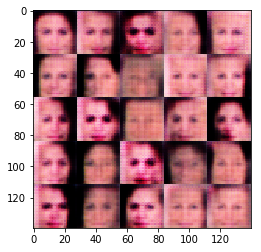

Epoch 1/1... Generator Loss: 2.4224 Discriminator Loss: 0.4932...
Epoch 1/1... Generator Loss: 1.9101 Discriminator Loss: 0.6223...
Epoch 1/1... Generator Loss: 4.1713 Discriminator Loss: 0.5713...
Epoch 1/1... Generator Loss: 2.6275 Discriminator Loss: 0.6795...
Epoch 1/1... Generator Loss: 4.0786 Discriminator Loss: 0.7649...
Epoch 1/1... Generator Loss: 6.1092 Discriminator Loss: 1.2508...
Epoch 1/1... Generator Loss: 1.5753 Discriminator Loss: 0.8523...
Epoch 1/1... Generator Loss: 1.8551 Discriminator Loss: 0.7277...
Epoch 1/1... Generator Loss: 2.3747 Discriminator Loss: 0.6484...
Epoch 1/1... Generator Loss: 2.6922 Discriminator Loss: 0.6103...


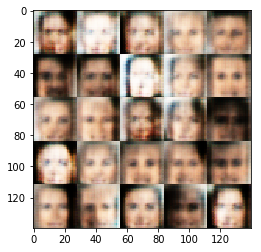

Epoch 1/1... Generator Loss: 2.8650 Discriminator Loss: 0.5634...
Epoch 1/1... Generator Loss: 2.3805 Discriminator Loss: 0.5980...
Epoch 1/1... Generator Loss: 1.5681 Discriminator Loss: 0.8116...
Epoch 1/1... Generator Loss: 2.6080 Discriminator Loss: 0.5695...
Epoch 1/1... Generator Loss: 3.6725 Discriminator Loss: 0.4478...
Epoch 1/1... Generator Loss: 3.3385 Discriminator Loss: 0.5697...
Epoch 1/1... Generator Loss: 2.9285 Discriminator Loss: 0.6343...
Epoch 1/1... Generator Loss: 2.8953 Discriminator Loss: 0.5998...
Epoch 1/1... Generator Loss: 2.8678 Discriminator Loss: 0.5772...
Epoch 1/1... Generator Loss: 2.9797 Discriminator Loss: 0.6392...


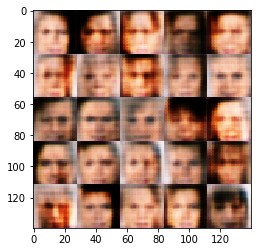

Epoch 1/1... Generator Loss: 2.5439 Discriminator Loss: 0.7360...
Epoch 1/1... Generator Loss: 2.5959 Discriminator Loss: 0.5283...
Epoch 1/1... Generator Loss: 2.4055 Discriminator Loss: 0.5598...
Epoch 1/1... Generator Loss: 5.6160 Discriminator Loss: 1.9332...
Epoch 1/1... Generator Loss: 2.0842 Discriminator Loss: 0.6832...
Epoch 1/1... Generator Loss: 2.7941 Discriminator Loss: 0.6218...
Epoch 1/1... Generator Loss: 0.8002 Discriminator Loss: 1.6229...
Epoch 1/1... Generator Loss: 1.9005 Discriminator Loss: 0.6250...
Epoch 1/1... Generator Loss: 2.3937 Discriminator Loss: 0.7817...
Epoch 1/1... Generator Loss: 2.0909 Discriminator Loss: 0.6556...


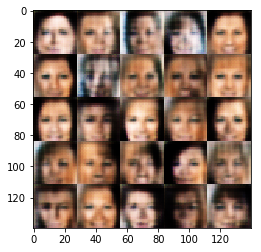

Epoch 1/1... Generator Loss: 3.0341 Discriminator Loss: 0.6144...
Epoch 1/1... Generator Loss: 2.4985 Discriminator Loss: 0.7960...
Epoch 1/1... Generator Loss: 1.8116 Discriminator Loss: 0.6918...
Epoch 1/1... Generator Loss: 1.9621 Discriminator Loss: 0.7516...
Epoch 1/1... Generator Loss: 2.2406 Discriminator Loss: 0.5804...
Epoch 1/1... Generator Loss: 1.5168 Discriminator Loss: 0.7079...
Epoch 1/1... Generator Loss: 2.9783 Discriminator Loss: 0.6353...
Epoch 1/1... Generator Loss: 2.1099 Discriminator Loss: 0.7324...
Epoch 1/1... Generator Loss: 2.5257 Discriminator Loss: 0.7054...
Epoch 1/1... Generator Loss: 3.7521 Discriminator Loss: 0.7421...


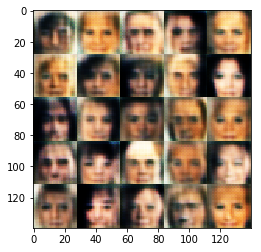

Epoch 1/1... Generator Loss: 2.6897 Discriminator Loss: 0.7417...
Epoch 1/1... Generator Loss: 2.9886 Discriminator Loss: 0.5355...
Epoch 1/1... Generator Loss: 1.5381 Discriminator Loss: 0.9725...
Epoch 1/1... Generator Loss: 2.3990 Discriminator Loss: 0.6778...
Epoch 1/1... Generator Loss: 2.3020 Discriminator Loss: 0.6239...
Epoch 1/1... Generator Loss: 2.2904 Discriminator Loss: 0.8998...
Epoch 1/1... Generator Loss: 2.3431 Discriminator Loss: 0.6688...
Epoch 1/1... Generator Loss: 3.8563 Discriminator Loss: 0.6004...
Epoch 1/1... Generator Loss: 2.9121 Discriminator Loss: 0.6166...
Epoch 1/1... Generator Loss: 2.2372 Discriminator Loss: 0.6409...


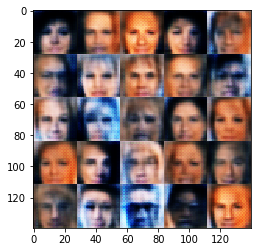

Epoch 1/1... Generator Loss: 2.9132 Discriminator Loss: 0.5667...
Epoch 1/1... Generator Loss: 1.9293 Discriminator Loss: 0.7597...
Epoch 1/1... Generator Loss: 1.2755 Discriminator Loss: 1.0422...
Epoch 1/1... Generator Loss: 2.1541 Discriminator Loss: 0.6372...
Epoch 1/1... Generator Loss: 1.5221 Discriminator Loss: 0.7146...
Epoch 1/1... Generator Loss: 3.4970 Discriminator Loss: 0.7000...
Epoch 1/1... Generator Loss: 2.6713 Discriminator Loss: 0.7955...
Epoch 1/1... Generator Loss: 2.5922 Discriminator Loss: 0.6649...
Epoch 1/1... Generator Loss: 2.7226 Discriminator Loss: 0.8131...
Epoch 1/1... Generator Loss: 2.0107 Discriminator Loss: 0.6884...


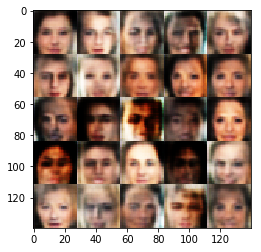

Epoch 1/1... Generator Loss: 0.9985 Discriminator Loss: 1.3034...
Epoch 1/1... Generator Loss: 2.3372 Discriminator Loss: 0.7666...
Epoch 1/1... Generator Loss: 2.0591 Discriminator Loss: 0.8046...
Epoch 1/1... Generator Loss: 2.3199 Discriminator Loss: 0.6245...
Epoch 1/1... Generator Loss: 1.7278 Discriminator Loss: 0.8959...
Epoch 1/1... Generator Loss: 2.9301 Discriminator Loss: 0.9384...
Epoch 1/1... Generator Loss: 3.1591 Discriminator Loss: 0.9019...
Epoch 1/1... Generator Loss: 3.2774 Discriminator Loss: 0.9889...
Epoch 1/1... Generator Loss: 2.6228 Discriminator Loss: 1.0649...
Epoch 1/1... Generator Loss: 1.8051 Discriminator Loss: 0.8061...


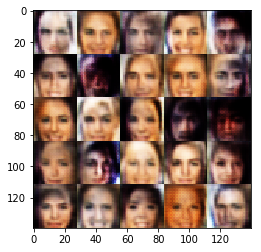

Epoch 1/1... Generator Loss: 1.6599 Discriminator Loss: 0.8823...
Epoch 1/1... Generator Loss: 1.9601 Discriminator Loss: 0.7954...
Epoch 1/1... Generator Loss: 1.4194 Discriminator Loss: 0.8399...
Epoch 1/1... Generator Loss: 1.0747 Discriminator Loss: 0.9552...
Epoch 1/1... Generator Loss: 2.7470 Discriminator Loss: 0.8251...
Epoch 1/1... Generator Loss: 1.2341 Discriminator Loss: 1.0031...
Epoch 1/1... Generator Loss: 1.1708 Discriminator Loss: 1.1552...
Epoch 1/1... Generator Loss: 2.0750 Discriminator Loss: 0.9592...
Epoch 1/1... Generator Loss: 3.3583 Discriminator Loss: 1.0265...
Epoch 1/1... Generator Loss: 1.5911 Discriminator Loss: 0.7403...


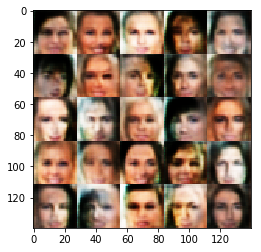

Epoch 1/1... Generator Loss: 1.7878 Discriminator Loss: 1.0645...
Epoch 1/1... Generator Loss: 1.8609 Discriminator Loss: 0.7259...
Epoch 1/1... Generator Loss: 1.6871 Discriminator Loss: 0.7910...
Epoch 1/1... Generator Loss: 2.6625 Discriminator Loss: 0.7103...
Epoch 1/1... Generator Loss: 1.8969 Discriminator Loss: 0.7725...
Epoch 1/1... Generator Loss: 3.0834 Discriminator Loss: 0.6177...
Epoch 1/1... Generator Loss: 1.5474 Discriminator Loss: 0.9406...
Epoch 1/1... Generator Loss: 2.7701 Discriminator Loss: 0.6662...
Epoch 1/1... Generator Loss: 1.9624 Discriminator Loss: 0.9987...
Epoch 1/1... Generator Loss: 1.8872 Discriminator Loss: 0.6718...


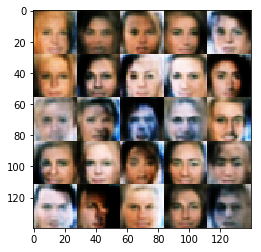

Epoch 1/1... Generator Loss: 1.9870 Discriminator Loss: 0.8444...
Epoch 1/1... Generator Loss: 2.0972 Discriminator Loss: 0.7591...
Epoch 1/1... Generator Loss: 2.0143 Discriminator Loss: 0.7935...
Epoch 1/1... Generator Loss: 1.9396 Discriminator Loss: 0.7018...
Epoch 1/1... Generator Loss: 2.7811 Discriminator Loss: 0.8730...
Epoch 1/1... Generator Loss: 2.0802 Discriminator Loss: 0.7746...
Epoch 1/1... Generator Loss: 1.9989 Discriminator Loss: 0.7940...
Epoch 1/1... Generator Loss: 1.7091 Discriminator Loss: 0.8126...
Epoch 1/1... Generator Loss: 2.2591 Discriminator Loss: 0.8458...
Epoch 1/1... Generator Loss: 1.7017 Discriminator Loss: 0.9193...


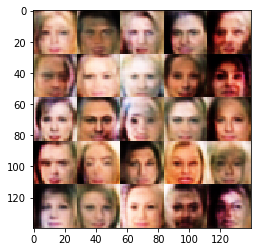

Epoch 1/1... Generator Loss: 1.3036 Discriminator Loss: 0.8579...
Epoch 1/1... Generator Loss: 1.6657 Discriminator Loss: 0.7427...
Epoch 1/1... Generator Loss: 1.9554 Discriminator Loss: 0.7468...
Epoch 1/1... Generator Loss: 2.5328 Discriminator Loss: 0.9437...
Epoch 1/1... Generator Loss: 1.7309 Discriminator Loss: 0.8782...
Epoch 1/1... Generator Loss: 2.9054 Discriminator Loss: 0.6259...
Epoch 1/1... Generator Loss: 1.8542 Discriminator Loss: 0.8062...
Epoch 1/1... Generator Loss: 2.5081 Discriminator Loss: 0.8083...
Epoch 1/1... Generator Loss: 1.9640 Discriminator Loss: 0.8118...
Epoch 1/1... Generator Loss: 1.5746 Discriminator Loss: 0.6823...


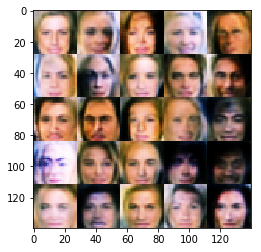

Epoch 1/1... Generator Loss: 1.8735 Discriminator Loss: 0.7222...
Epoch 1/1... Generator Loss: 2.1613 Discriminator Loss: 0.9377...
Epoch 1/1... Generator Loss: 2.1999 Discriminator Loss: 0.7193...
Epoch 1/1... Generator Loss: 1.9422 Discriminator Loss: 0.8812...
Epoch 1/1... Generator Loss: 1.8606 Discriminator Loss: 0.9248...
Epoch 1/1... Generator Loss: 1.7227 Discriminator Loss: 0.6371...
Epoch 1/1... Generator Loss: 1.5465 Discriminator Loss: 0.8153...
Epoch 1/1... Generator Loss: 1.6395 Discriminator Loss: 0.7366...
Epoch 1/1... Generator Loss: 2.1235 Discriminator Loss: 0.7711...
Epoch 1/1... Generator Loss: 1.9268 Discriminator Loss: 0.7471...


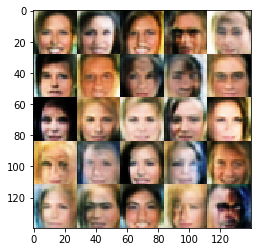

Epoch 1/1... Generator Loss: 1.5730 Discriminator Loss: 0.8315...
Epoch 1/1... Generator Loss: 1.7237 Discriminator Loss: 0.8934...
Epoch 1/1... Generator Loss: 2.5792 Discriminator Loss: 0.8814...
Epoch 1/1... Generator Loss: 1.3787 Discriminator Loss: 0.8664...
Epoch 1/1... Generator Loss: 1.8473 Discriminator Loss: 0.8552...
Epoch 1/1... Generator Loss: 1.7275 Discriminator Loss: 0.7973...
Epoch 1/1... Generator Loss: 1.7671 Discriminator Loss: 0.8133...
Epoch 1/1... Generator Loss: 1.4487 Discriminator Loss: 0.7713...
Epoch 1/1... Generator Loss: 2.1628 Discriminator Loss: 0.7254...
Epoch 1/1... Generator Loss: 1.5051 Discriminator Loss: 0.7965...


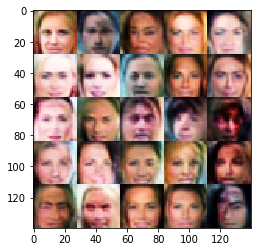

Epoch 1/1... Generator Loss: 1.2474 Discriminator Loss: 0.8325...
Epoch 1/1... Generator Loss: 1.8492 Discriminator Loss: 0.6182...
Epoch 1/1... Generator Loss: 2.1790 Discriminator Loss: 0.8899...
Epoch 1/1... Generator Loss: 1.7781 Discriminator Loss: 0.7343...
Epoch 1/1... Generator Loss: 2.0286 Discriminator Loss: 0.8174...
Epoch 1/1... Generator Loss: 1.9938 Discriminator Loss: 0.7304...
Epoch 1/1... Generator Loss: 1.6064 Discriminator Loss: 0.8176...
Epoch 1/1... Generator Loss: 2.6507 Discriminator Loss: 0.8368...
Epoch 1/1... Generator Loss: 2.3726 Discriminator Loss: 0.6650...
Epoch 1/1... Generator Loss: 1.6143 Discriminator Loss: 0.8446...


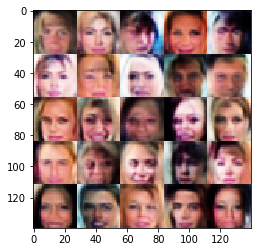

Epoch 1/1... Generator Loss: 1.9214 Discriminator Loss: 0.8582...
Epoch 1/1... Generator Loss: 1.1614 Discriminator Loss: 1.0187...
Epoch 1/1... Generator Loss: 1.9068 Discriminator Loss: 0.7371...
Epoch 1/1... Generator Loss: 1.3024 Discriminator Loss: 0.8979...
Epoch 1/1... Generator Loss: 2.0998 Discriminator Loss: 0.8523...
Epoch 1/1... Generator Loss: 1.3728 Discriminator Loss: 0.9265...
Epoch 1/1... Generator Loss: 2.3061 Discriminator Loss: 0.9637...
Epoch 1/1... Generator Loss: 1.1572 Discriminator Loss: 0.9565...
Epoch 1/1... Generator Loss: 2.1805 Discriminator Loss: 0.7843...
Epoch 1/1... Generator Loss: 1.5574 Discriminator Loss: 0.9120...


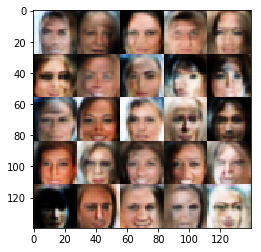

Epoch 1/1... Generator Loss: 1.2602 Discriminator Loss: 0.7281...
Epoch 1/1... Generator Loss: 1.8973 Discriminator Loss: 0.9054...
Epoch 1/1... Generator Loss: 2.1170 Discriminator Loss: 0.8844...
Epoch 1/1... Generator Loss: 1.5889 Discriminator Loss: 0.6835...
Epoch 1/1... Generator Loss: 1.7105 Discriminator Loss: 0.7548...
Epoch 1/1... Generator Loss: 1.3203 Discriminator Loss: 1.0675...
Epoch 1/1... Generator Loss: 1.5880 Discriminator Loss: 0.7226...
Epoch 1/1... Generator Loss: 2.3165 Discriminator Loss: 0.8417...
Epoch 1/1... Generator Loss: 1.8663 Discriminator Loss: 0.8489...
Epoch 1/1... Generator Loss: 1.9228 Discriminator Loss: 0.7176...


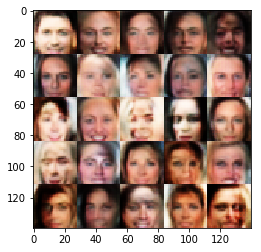

Epoch 1/1... Generator Loss: 1.0256 Discriminator Loss: 1.0949...
Epoch 1/1... Generator Loss: 1.5155 Discriminator Loss: 0.7545...
Epoch 1/1... Generator Loss: 1.8935 Discriminator Loss: 0.7516...
Epoch 1/1... Generator Loss: 1.6106 Discriminator Loss: 0.8181...
Epoch 1/1... Generator Loss: 2.3361 Discriminator Loss: 0.7104...
Epoch 1/1... Generator Loss: 1.7029 Discriminator Loss: 0.7874...
Epoch 1/1... Generator Loss: 1.4826 Discriminator Loss: 0.8996...
Epoch 1/1... Generator Loss: 3.1525 Discriminator Loss: 0.8274...
Epoch 1/1... Generator Loss: 2.1046 Discriminator Loss: 0.7203...
Epoch 1/1... Generator Loss: 2.4268 Discriminator Loss: 0.6280...


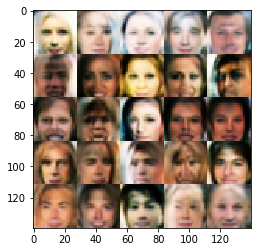

Epoch 1/1... Generator Loss: 1.2252 Discriminator Loss: 0.9314...
Epoch 1/1... Generator Loss: 2.7378 Discriminator Loss: 1.2000...
Epoch 1/1... Generator Loss: 1.6257 Discriminator Loss: 0.7603...
Epoch 1/1... Generator Loss: 1.9355 Discriminator Loss: 0.6367...
Epoch 1/1... Generator Loss: 1.9264 Discriminator Loss: 0.7113...
Epoch 1/1... Generator Loss: 2.3243 Discriminator Loss: 0.5966...
Epoch 1/1... Generator Loss: 0.9497 Discriminator Loss: 1.2694...
Epoch 1/1... Generator Loss: 1.4749 Discriminator Loss: 0.7771...
Epoch 1/1... Generator Loss: 1.2155 Discriminator Loss: 1.0146...
Epoch 1/1... Generator Loss: 2.0676 Discriminator Loss: 0.7243...


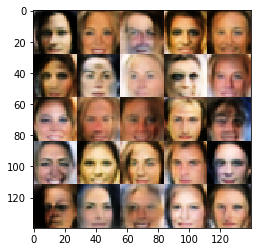

Epoch 1/1... Generator Loss: 0.8265 Discriminator Loss: 1.1768...
Epoch 1/1... Generator Loss: 1.9116 Discriminator Loss: 0.7490...
Epoch 1/1... Generator Loss: 1.0891 Discriminator Loss: 0.9402...
Epoch 1/1... Generator Loss: 1.2796 Discriminator Loss: 0.8236...
Epoch 1/1... Generator Loss: 1.8410 Discriminator Loss: 0.8132...
Epoch 1/1... Generator Loss: 1.5052 Discriminator Loss: 0.9164...
Epoch 1/1... Generator Loss: 1.5268 Discriminator Loss: 0.9185...
Epoch 1/1... Generator Loss: 1.3738 Discriminator Loss: 0.9187...
Epoch 1/1... Generator Loss: 2.2653 Discriminator Loss: 0.8477...
Epoch 1/1... Generator Loss: 1.4706 Discriminator Loss: 0.7515...


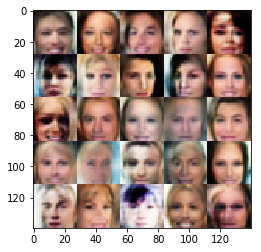

Epoch 1/1... Generator Loss: 1.7548 Discriminator Loss: 0.8578...
Epoch 1/1... Generator Loss: 2.3479 Discriminator Loss: 0.8190...
Epoch 1/1... Generator Loss: 1.6509 Discriminator Loss: 0.8764...
Epoch 1/1... Generator Loss: 1.9629 Discriminator Loss: 0.7269...
Epoch 1/1... Generator Loss: 1.6767 Discriminator Loss: 0.7711...
Epoch 1/1... Generator Loss: 1.3921 Discriminator Loss: 0.7713...
Epoch 1/1... Generator Loss: 2.5367 Discriminator Loss: 0.6798...
Epoch 1/1... Generator Loss: 1.9668 Discriminator Loss: 0.9107...
Epoch 1/1... Generator Loss: 2.3786 Discriminator Loss: 0.5761...
Epoch 1/1... Generator Loss: 1.2662 Discriminator Loss: 0.8992...


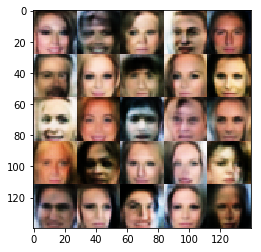

Epoch 1/1... Generator Loss: 1.7669 Discriminator Loss: 0.8128...
Epoch 1/1... Generator Loss: 1.5795 Discriminator Loss: 0.6834...
Epoch 1/1... Generator Loss: 2.0090 Discriminator Loss: 0.7084...
Epoch 1/1... Generator Loss: 1.8736 Discriminator Loss: 0.6829...
Epoch 1/1... Generator Loss: 1.4890 Discriminator Loss: 0.8742...
Epoch 1/1... Generator Loss: 1.6478 Discriminator Loss: 0.8955...
Epoch 1/1... Generator Loss: 1.7913 Discriminator Loss: 0.6802...
Epoch 1/1... Generator Loss: 1.5060 Discriminator Loss: 0.7263...
Epoch 1/1... Generator Loss: 1.9377 Discriminator Loss: 0.6562...
Epoch 1/1... Generator Loss: 1.8823 Discriminator Loss: 0.7358...


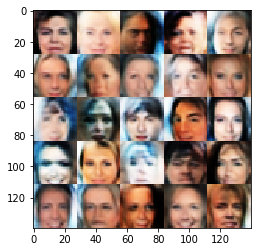

Epoch 1/1... Generator Loss: 1.3177 Discriminator Loss: 0.9505...
Epoch 1/1... Generator Loss: 2.5630 Discriminator Loss: 0.7349...
Epoch 1/1... Generator Loss: 1.7880 Discriminator Loss: 0.6937...
Epoch 1/1... Generator Loss: 1.5921 Discriminator Loss: 0.7943...
Epoch 1/1... Generator Loss: 1.4987 Discriminator Loss: 0.8570...
Epoch 1/1... Generator Loss: 0.7453 Discriminator Loss: 1.2299...
Epoch 1/1... Generator Loss: 1.5813 Discriminator Loss: 0.7632...
Epoch 1/1... Generator Loss: 2.0496 Discriminator Loss: 0.8318...
Epoch 1/1... Generator Loss: 1.8418 Discriminator Loss: 0.7066...
Epoch 1/1... Generator Loss: 2.6099 Discriminator Loss: 0.8870...


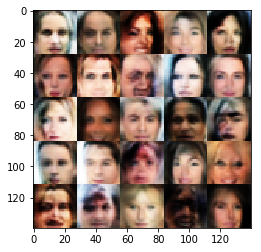

Epoch 1/1... Generator Loss: 1.9072 Discriminator Loss: 0.7938...
Epoch 1/1... Generator Loss: 0.9609 Discriminator Loss: 0.9923...
Epoch 1/1... Generator Loss: 1.2976 Discriminator Loss: 0.9432...
Epoch 1/1... Generator Loss: 1.7024 Discriminator Loss: 0.8106...
Epoch 1/1... Generator Loss: 1.7027 Discriminator Loss: 0.7993...
Epoch 1/1... Generator Loss: 1.4486 Discriminator Loss: 0.7334...
Epoch 1/1... Generator Loss: 1.6780 Discriminator Loss: 0.7555...
Epoch 1/1... Generator Loss: 1.7125 Discriminator Loss: 0.7551...
Epoch 1/1... Generator Loss: 1.9081 Discriminator Loss: 0.7360...
Epoch 1/1... Generator Loss: 2.1767 Discriminator Loss: 0.6589...


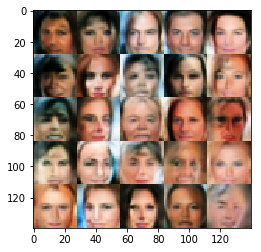

Epoch 1/1... Generator Loss: 1.7936 Discriminator Loss: 0.8309...
Epoch 1/1... Generator Loss: 1.0064 Discriminator Loss: 0.9947...
Epoch 1/1... Generator Loss: 1.9240 Discriminator Loss: 0.6748...
Epoch 1/1... Generator Loss: 2.3909 Discriminator Loss: 0.8158...
Epoch 1/1... Generator Loss: 2.0962 Discriminator Loss: 0.8892...
Epoch 1/1... Generator Loss: 1.7222 Discriminator Loss: 0.7546...
Epoch 1/1... Generator Loss: 1.2792 Discriminator Loss: 0.7103...
Epoch 1/1... Generator Loss: 1.4095 Discriminator Loss: 0.6210...
Epoch 1/1... Generator Loss: 2.2052 Discriminator Loss: 0.8608...
Epoch 1/1... Generator Loss: 1.7401 Discriminator Loss: 0.8023...


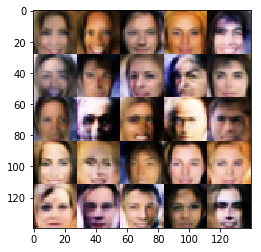

Epoch 1/1... Generator Loss: 2.3128 Discriminator Loss: 0.7085...
Epoch 1/1... Generator Loss: 1.2689 Discriminator Loss: 0.8719...
Epoch 1/1... Generator Loss: 1.8688 Discriminator Loss: 0.8495...
Epoch 1/1... Generator Loss: 1.0368 Discriminator Loss: 0.9694...
Epoch 1/1... Generator Loss: 1.9874 Discriminator Loss: 0.7651...
Epoch 1/1... Generator Loss: 1.8463 Discriminator Loss: 0.8790...
Epoch 1/1... Generator Loss: 2.0263 Discriminator Loss: 0.8816...
Epoch 1/1... Generator Loss: 2.1532 Discriminator Loss: 0.9748...
Epoch 1/1... Generator Loss: 1.7945 Discriminator Loss: 0.8719...
Epoch 1/1... Generator Loss: 1.7240 Discriminator Loss: 0.6746...


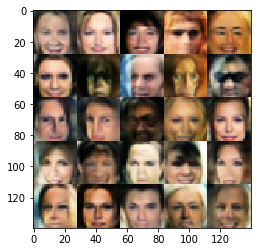

Epoch 1/1... Generator Loss: 1.7796 Discriminator Loss: 0.8739...
Epoch 1/1... Generator Loss: 2.4046 Discriminator Loss: 0.9123...
Epoch 1/1... Generator Loss: 1.8811 Discriminator Loss: 0.7102...
Epoch 1/1... Generator Loss: 1.7731 Discriminator Loss: 0.7516...
Epoch 1/1... Generator Loss: 1.5491 Discriminator Loss: 0.7682...
Epoch 1/1... Generator Loss: 1.0757 Discriminator Loss: 1.0437...
Epoch 1/1... Generator Loss: 1.3990 Discriminator Loss: 0.8892...
Epoch 1/1... Generator Loss: 0.9013 Discriminator Loss: 1.0393...
Epoch 1/1... Generator Loss: 1.6701 Discriminator Loss: 0.7929...
Epoch 1/1... Generator Loss: 3.1181 Discriminator Loss: 0.9034...


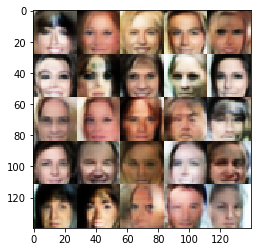

Epoch 1/1... Generator Loss: 1.7900 Discriminator Loss: 0.7624...
Epoch 1/1... Generator Loss: 1.4917 Discriminator Loss: 1.0637...
Epoch 1/1... Generator Loss: 1.2971 Discriminator Loss: 0.8831...
Epoch 1/1... Generator Loss: 1.2389 Discriminator Loss: 0.8795...
Epoch 1/1... Generator Loss: 1.0787 Discriminator Loss: 1.1104...
Epoch 1/1... Generator Loss: 0.7636 Discriminator Loss: 0.8598...
Epoch 1/1... Generator Loss: 1.8797 Discriminator Loss: 0.7691...
Epoch 1/1... Generator Loss: 1.9133 Discriminator Loss: 0.8712...
Epoch 1/1... Generator Loss: 0.8519 Discriminator Loss: 1.1134...
Epoch 1/1... Generator Loss: 2.3610 Discriminator Loss: 0.8346...


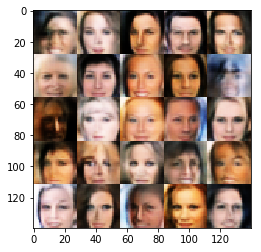

Epoch 1/1... Generator Loss: 1.5045 Discriminator Loss: 0.7987...
Epoch 1/1... Generator Loss: 2.4954 Discriminator Loss: 0.6445...
Epoch 1/1... Generator Loss: 2.4983 Discriminator Loss: 0.9196...
Epoch 1/1... Generator Loss: 2.0477 Discriminator Loss: 0.6563...
Epoch 1/1... Generator Loss: 1.8382 Discriminator Loss: 0.8930...
Epoch 1/1... Generator Loss: 1.9470 Discriminator Loss: 0.6931...
Epoch 1/1... Generator Loss: 2.2991 Discriminator Loss: 0.9175...
Epoch 1/1... Generator Loss: 1.6729 Discriminator Loss: 0.6751...
Epoch 1/1... Generator Loss: 1.7275 Discriminator Loss: 0.9702...
Epoch 1/1... Generator Loss: 1.7613 Discriminator Loss: 0.7221...


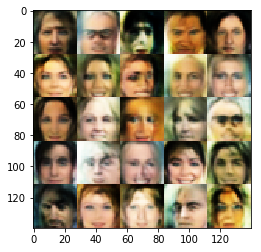

Epoch 1/1... Generator Loss: 1.9532 Discriminator Loss: 0.6774...
Epoch 1/1... Generator Loss: 2.6578 Discriminator Loss: 0.7790...
Epoch 1/1... Generator Loss: 0.8184 Discriminator Loss: 1.0403...
Epoch 1/1... Generator Loss: 1.3922 Discriminator Loss: 0.8366...
Epoch 1/1... Generator Loss: 1.5684 Discriminator Loss: 0.9935...
Epoch 1/1... Generator Loss: 2.6454 Discriminator Loss: 0.6367...
Epoch 1/1... Generator Loss: 1.7712 Discriminator Loss: 0.8107...
Epoch 1/1... Generator Loss: 2.4796 Discriminator Loss: 0.8166...
Epoch 1/1... Generator Loss: 1.2977 Discriminator Loss: 0.9801...
Epoch 1/1... Generator Loss: 1.4620 Discriminator Loss: 1.2293...


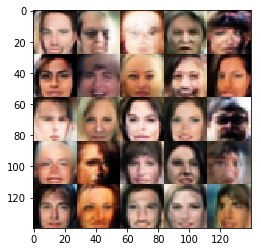

Epoch 1/1... Generator Loss: 2.1324 Discriminator Loss: 0.7214...
Epoch 1/1... Generator Loss: 1.6906 Discriminator Loss: 0.7957...
Epoch 1/1... Generator Loss: 1.7064 Discriminator Loss: 0.8762...
Epoch 1/1... Generator Loss: 2.2387 Discriminator Loss: 0.8903...
Epoch 1/1... Generator Loss: 2.8872 Discriminator Loss: 0.5966...
Epoch 1/1... Generator Loss: 2.2529 Discriminator Loss: 0.7768...
Epoch 1/1... Generator Loss: 1.5925 Discriminator Loss: 0.9921...
Epoch 1/1... Generator Loss: 1.2308 Discriminator Loss: 0.8002...
Epoch 1/1... Generator Loss: 1.5243 Discriminator Loss: 0.8112...
Epoch 1/1... Generator Loss: 1.7775 Discriminator Loss: 0.8459...


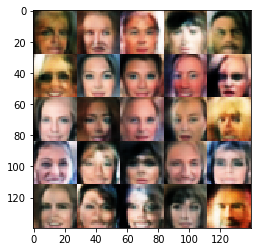

Epoch 1/1... Generator Loss: 1.4503 Discriminator Loss: 0.8234...
Epoch 1/1... Generator Loss: 1.2532 Discriminator Loss: 0.8756...
Epoch 1/1... Generator Loss: 2.6746 Discriminator Loss: 0.8185...
Epoch 1/1... Generator Loss: 2.5124 Discriminator Loss: 0.7184...
Epoch 1/1... Generator Loss: 1.6965 Discriminator Loss: 0.7736...
Epoch 1/1... Generator Loss: 1.3509 Discriminator Loss: 0.8280...
Epoch 1/1... Generator Loss: 2.3319 Discriminator Loss: 0.8630...
Epoch 1/1... Generator Loss: 1.5592 Discriminator Loss: 0.8236...
Epoch 1/1... Generator Loss: 1.4959 Discriminator Loss: 0.9242...
Epoch 1/1... Generator Loss: 1.7384 Discriminator Loss: 0.8501...


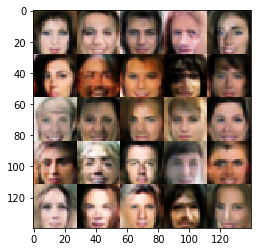

Epoch 1/1... Generator Loss: 1.5909 Discriminator Loss: 0.9920...
Epoch 1/1... Generator Loss: 2.2912 Discriminator Loss: 0.8202...
Epoch 1/1... Generator Loss: 2.4789 Discriminator Loss: 0.8274...
Epoch 1/1... Generator Loss: 1.6808 Discriminator Loss: 0.6876...
Epoch 1/1... Generator Loss: 1.5821 Discriminator Loss: 0.8415...
Epoch 1/1... Generator Loss: 1.6219 Discriminator Loss: 0.9035...
Epoch 1/1... Generator Loss: 1.7316 Discriminator Loss: 0.7548...
Epoch 1/1... Generator Loss: 2.0318 Discriminator Loss: 0.7263...
Epoch 1/1... Generator Loss: 1.5365 Discriminator Loss: 0.7671...
Epoch 1/1... Generator Loss: 1.9230 Discriminator Loss: 0.7966...


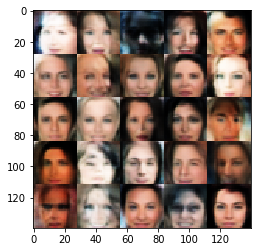

Epoch 1/1... Generator Loss: 0.8559 Discriminator Loss: 1.1742...
Epoch 1/1... Generator Loss: 0.8773 Discriminator Loss: 0.8878...
Epoch 1/1... Generator Loss: 1.7536 Discriminator Loss: 0.7742...
Epoch 1/1... Generator Loss: 1.5369 Discriminator Loss: 0.6804...
Epoch 1/1... Generator Loss: 2.2246 Discriminator Loss: 0.6971...
Epoch 1/1... Generator Loss: 2.0389 Discriminator Loss: 0.9028...
Epoch 1/1... Generator Loss: 1.5854 Discriminator Loss: 0.8179...
Epoch 1/1... Generator Loss: 2.1646 Discriminator Loss: 0.6871...
Epoch 1/1... Generator Loss: 2.0265 Discriminator Loss: 0.7341...
Epoch 1/1... Generator Loss: 1.8561 Discriminator Loss: 0.7457...


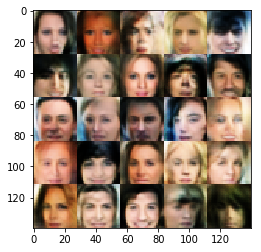

Epoch 1/1... Generator Loss: 1.9466 Discriminator Loss: 0.7767...
Epoch 1/1... Generator Loss: 1.5105 Discriminator Loss: 0.7574...
Epoch 1/1... Generator Loss: 1.7353 Discriminator Loss: 0.7607...
Epoch 1/1... Generator Loss: 1.5362 Discriminator Loss: 0.7457...
Epoch 1/1... Generator Loss: 1.3983 Discriminator Loss: 0.7688...
Epoch 1/1... Generator Loss: 1.8228 Discriminator Loss: 0.7657...
Epoch 1/1... Generator Loss: 1.8103 Discriminator Loss: 0.7674...
Epoch 1/1... Generator Loss: 1.3063 Discriminator Loss: 0.8399...
Epoch 1/1... Generator Loss: 1.0715 Discriminator Loss: 0.8851...
Epoch 1/1... Generator Loss: 1.5743 Discriminator Loss: 0.6826...


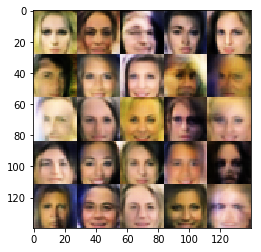

Epoch 1/1... Generator Loss: 2.0347 Discriminator Loss: 0.7057...
Epoch 1/1... Generator Loss: 1.6251 Discriminator Loss: 0.7284...
Epoch 1/1... Generator Loss: 1.4584 Discriminator Loss: 0.9966...
Epoch 1/1... Generator Loss: 1.5372 Discriminator Loss: 0.7249...
Epoch 1/1... Generator Loss: 2.3071 Discriminator Loss: 1.0032...
Epoch 1/1... Generator Loss: 1.8577 Discriminator Loss: 0.8461...
Epoch 1/1... Generator Loss: 1.8506 Discriminator Loss: 0.6830...
Epoch 1/1... Generator Loss: 2.1540 Discriminator Loss: 0.8026...
Epoch 1/1... Generator Loss: 1.2541 Discriminator Loss: 0.8597...
Epoch 1/1... Generator Loss: 1.7730 Discriminator Loss: 0.6804...


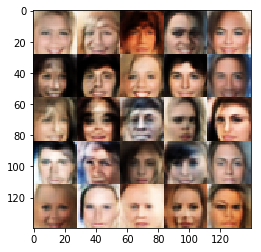

Epoch 1/1... Generator Loss: 1.3621 Discriminator Loss: 0.8326...
Epoch 1/1... Generator Loss: 2.5316 Discriminator Loss: 0.6502...
Epoch 1/1... Generator Loss: 1.8153 Discriminator Loss: 0.8226...
Epoch 1/1... Generator Loss: 1.3861 Discriminator Loss: 0.7682...
Epoch 1/1... Generator Loss: 1.5875 Discriminator Loss: 0.7880...
Epoch 1/1... Generator Loss: 1.4647 Discriminator Loss: 0.7261...
Epoch 1/1... Generator Loss: 1.5925 Discriminator Loss: 0.7414...
Epoch 1/1... Generator Loss: 2.3288 Discriminator Loss: 0.7333...
Epoch 1/1... Generator Loss: 1.9538 Discriminator Loss: 0.7870...
Epoch 1/1... Generator Loss: 1.3733 Discriminator Loss: 0.7348...


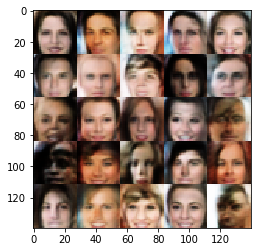

Epoch 1/1... Generator Loss: 1.0475 Discriminator Loss: 0.8345...
Epoch 1/1... Generator Loss: 2.3133 Discriminator Loss: 0.8878...
Epoch 1/1... Generator Loss: 1.3533 Discriminator Loss: 0.8480...
Epoch 1/1... Generator Loss: 1.5494 Discriminator Loss: 0.9023...
Epoch 1/1... Generator Loss: 2.3873 Discriminator Loss: 1.0606...
Epoch 1/1... Generator Loss: 2.0817 Discriminator Loss: 0.6854...
Epoch 1/1... Generator Loss: 1.7785 Discriminator Loss: 0.9323...
Epoch 1/1... Generator Loss: 1.9378 Discriminator Loss: 0.7855...
Epoch 1/1... Generator Loss: 1.4306 Discriminator Loss: 1.0257...
Epoch 1/1... Generator Loss: 1.8922 Discriminator Loss: 0.8086...


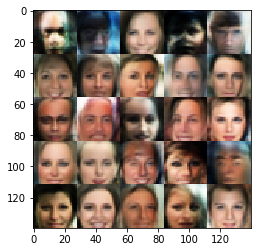

Epoch 1/1... Generator Loss: 1.3666 Discriminator Loss: 0.8338...
Epoch 1/1... Generator Loss: 1.9441 Discriminator Loss: 0.7751...
Epoch 1/1... Generator Loss: 1.4613 Discriminator Loss: 0.8682...
Epoch 1/1... Generator Loss: 1.7335 Discriminator Loss: 0.8022...
Epoch 1/1... Generator Loss: 1.7163 Discriminator Loss: 0.8030...
Epoch 1/1... Generator Loss: 1.9826 Discriminator Loss: 0.8027...
Epoch 1/1... Generator Loss: 1.6330 Discriminator Loss: 0.8010...
Epoch 1/1... Generator Loss: 2.0758 Discriminator Loss: 0.8274...
Epoch 1/1... Generator Loss: 2.8127 Discriminator Loss: 0.7499...
Epoch 1/1... Generator Loss: 2.0653 Discriminator Loss: 0.7041...


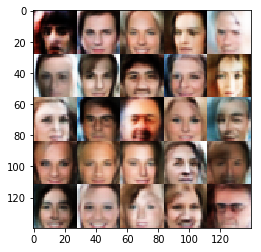

Epoch 1/1... Generator Loss: 1.2992 Discriminator Loss: 0.8865...
Epoch 1/1... Generator Loss: 1.3040 Discriminator Loss: 1.0435...
Epoch 1/1... Generator Loss: 2.2407 Discriminator Loss: 0.8695...
Epoch 1/1... Generator Loss: 2.3205 Discriminator Loss: 0.7239...
Epoch 1/1... Generator Loss: 1.1209 Discriminator Loss: 1.0532...
Epoch 1/1... Generator Loss: 1.5492 Discriminator Loss: 0.7637...
Epoch 1/1... Generator Loss: 1.8067 Discriminator Loss: 0.8090...
Epoch 1/1... Generator Loss: 1.1430 Discriminator Loss: 0.9418...
Epoch 1/1... Generator Loss: 1.7525 Discriminator Loss: 0.6884...
Epoch 1/1... Generator Loss: 1.1985 Discriminator Loss: 0.8667...


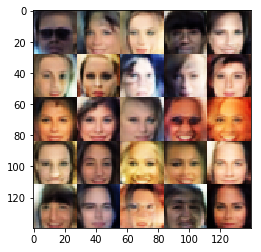

Epoch 1/1... Generator Loss: 2.2443 Discriminator Loss: 0.7262...
Epoch 1/1... Generator Loss: 0.8751 Discriminator Loss: 1.1993...
Epoch 1/1... Generator Loss: 1.9913 Discriminator Loss: 0.6029...
Epoch 1/1... Generator Loss: 2.9124 Discriminator Loss: 0.5579...
Epoch 1/1... Generator Loss: 2.0629 Discriminator Loss: 0.7199...
Epoch 1/1... Generator Loss: 1.7715 Discriminator Loss: 0.8403...
Epoch 1/1... Generator Loss: 2.0688 Discriminator Loss: 0.6761...
Epoch 1/1... Generator Loss: 1.8861 Discriminator Loss: 0.6311...
Epoch 1/1... Generator Loss: 1.9734 Discriminator Loss: 0.7824...
Epoch 1/1... Generator Loss: 0.7707 Discriminator Loss: 1.3463...


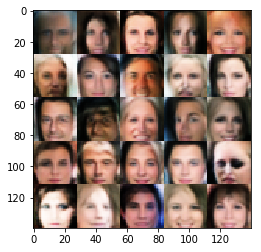

Epoch 1/1... Generator Loss: 1.7515 Discriminator Loss: 0.7495...
Epoch 1/1... Generator Loss: 2.1072 Discriminator Loss: 0.6892...
Epoch 1/1... Generator Loss: 1.3186 Discriminator Loss: 0.7592...
Epoch 1/1... Generator Loss: 1.6963 Discriminator Loss: 0.6313...
Epoch 1/1... Generator Loss: 1.7228 Discriminator Loss: 0.8006...
Epoch 1/1... Generator Loss: 1.3598 Discriminator Loss: 0.8089...
Epoch 1/1... Generator Loss: 2.1938 Discriminator Loss: 0.6828...
Epoch 1/1... Generator Loss: 1.1675 Discriminator Loss: 0.9542...
Epoch 1/1... Generator Loss: 1.8602 Discriminator Loss: 0.7880...
Epoch 1/1... Generator Loss: 1.9437 Discriminator Loss: 0.7876...


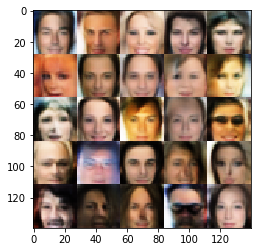

Epoch 1/1... Generator Loss: 0.7130 Discriminator Loss: 1.0288...
Epoch 1/1... Generator Loss: 2.5564 Discriminator Loss: 0.7581...
Epoch 1/1... Generator Loss: 1.7741 Discriminator Loss: 0.6860...
Epoch 1/1... Generator Loss: 2.0173 Discriminator Loss: 0.7596...
Epoch 1/1... Generator Loss: 1.5863 Discriminator Loss: 0.6841...
Epoch 1/1... Generator Loss: 1.2992 Discriminator Loss: 0.8424...
Epoch 1/1... Generator Loss: 2.0521 Discriminator Loss: 0.7624...
Epoch 1/1... Generator Loss: 1.6888 Discriminator Loss: 0.8048...
Epoch 1/1... Generator Loss: 2.0933 Discriminator Loss: 0.7431...
Epoch 1/1... Generator Loss: 1.5859 Discriminator Loss: 0.9205...


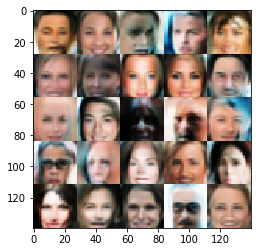

Epoch 1/1... Generator Loss: 1.7909 Discriminator Loss: 0.7411...
Epoch 1/1... Generator Loss: 2.1062 Discriminator Loss: 0.8015...
Epoch 1/1... Generator Loss: 1.3377 Discriminator Loss: 1.0937...
Epoch 1/1... Generator Loss: 2.2289 Discriminator Loss: 0.6605...
Epoch 1/1... Generator Loss: 1.7686 Discriminator Loss: 0.7533...
Epoch 1/1... Generator Loss: 1.8590 Discriminator Loss: 0.6251...
Epoch 1/1... Generator Loss: 1.7369 Discriminator Loss: 0.7504...
Epoch 1/1... Generator Loss: 1.4150 Discriminator Loss: 0.7549...
Epoch 1/1... Generator Loss: 1.5065 Discriminator Loss: 0.9194...
Epoch 1/1... Generator Loss: 1.5073 Discriminator Loss: 0.8319...


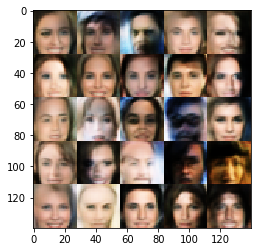

Epoch 1/1... Generator Loss: 1.4560 Discriminator Loss: 0.8305...
Epoch 1/1... Generator Loss: 1.7460 Discriminator Loss: 0.8404...
Epoch 1/1... Generator Loss: 2.3531 Discriminator Loss: 0.6587...
Epoch 1/1... Generator Loss: 1.4479 Discriminator Loss: 0.6937...
Epoch 1/1... Generator Loss: 1.2362 Discriminator Loss: 0.7158...
Epoch 1/1... Generator Loss: 1.8488 Discriminator Loss: 0.7866...
Epoch 1/1... Generator Loss: 2.1510 Discriminator Loss: 0.6250...
Epoch 1/1... Generator Loss: 1.8450 Discriminator Loss: 0.6798...
Epoch 1/1... Generator Loss: 1.4681 Discriminator Loss: 0.7396...
Epoch 1/1... Generator Loss: 1.6833 Discriminator Loss: 0.6308...


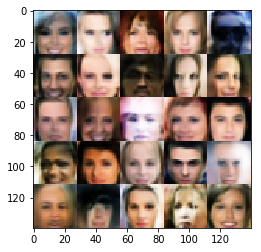

Epoch 1/1... Generator Loss: 1.7275 Discriminator Loss: 0.9376...
Epoch 1/1... Generator Loss: 1.9530 Discriminator Loss: 0.6830...
Epoch 1/1... Generator Loss: 2.5982 Discriminator Loss: 0.5994...
Epoch 1/1... Generator Loss: 2.6103 Discriminator Loss: 0.6507...
Epoch 1/1... Generator Loss: 3.0501 Discriminator Loss: 0.9200...
Epoch 1/1... Generator Loss: 1.5832 Discriminator Loss: 0.8658...
Epoch 1/1... Generator Loss: 1.7082 Discriminator Loss: 0.7954...
Epoch 1/1... Generator Loss: 1.0752 Discriminator Loss: 0.8757...
Epoch 1/1... Generator Loss: 1.8115 Discriminator Loss: 0.7013...
Epoch 1/1... Generator Loss: 1.7446 Discriminator Loss: 0.5688...


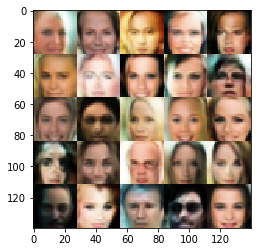

Epoch 1/1... Generator Loss: 1.6712 Discriminator Loss: 0.6801...
Epoch 1/1... Generator Loss: 2.6851 Discriminator Loss: 0.5506...
Epoch 1/1... Generator Loss: 1.0214 Discriminator Loss: 0.8682...
Epoch 1/1... Generator Loss: 1.5127 Discriminator Loss: 0.8988...
Epoch 1/1... Generator Loss: 2.5726 Discriminator Loss: 0.7028...
Epoch 1/1... Generator Loss: 2.0410 Discriminator Loss: 0.6353...
Epoch 1/1... Generator Loss: 2.7435 Discriminator Loss: 0.5736...
Epoch 1/1... Generator Loss: 1.5763 Discriminator Loss: 0.9719...
Epoch 1/1... Generator Loss: 2.1531 Discriminator Loss: 0.7832...
Epoch 1/1... Generator Loss: 2.3619 Discriminator Loss: 0.5821...


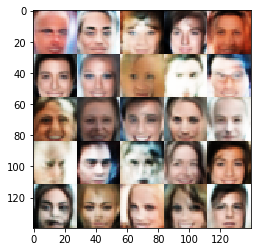

Epoch 1/1... Generator Loss: 1.2115 Discriminator Loss: 0.8457...
Epoch 1/1... Generator Loss: 1.9202 Discriminator Loss: 0.9447...
Epoch 1/1... Generator Loss: 1.8022 Discriminator Loss: 0.6777...
Epoch 1/1... Generator Loss: 2.0115 Discriminator Loss: 0.6420...
Epoch 1/1... Generator Loss: 1.0544 Discriminator Loss: 0.8770...
Epoch 1/1... Generator Loss: 1.1465 Discriminator Loss: 0.7263...
Epoch 1/1... Generator Loss: 1.7621 Discriminator Loss: 0.7329...
Epoch 1/1... Generator Loss: 2.0945 Discriminator Loss: 0.7147...
Epoch 1/1... Generator Loss: 1.2969 Discriminator Loss: 0.8890...
Epoch 1/1... Generator Loss: 2.0809 Discriminator Loss: 0.7294...


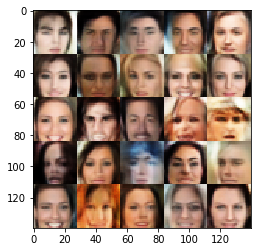

Epoch 1/1... Generator Loss: 1.8907 Discriminator Loss: 0.6188...
Epoch 1/1... Generator Loss: 2.4173 Discriminator Loss: 0.7575...
Epoch 1/1... Generator Loss: 0.6839 Discriminator Loss: 1.0827...
Epoch 1/1... Generator Loss: 2.7711 Discriminator Loss: 0.7131...
Epoch 1/1... Generator Loss: 1.2599 Discriminator Loss: 0.8486...
Epoch 1/1... Generator Loss: 2.0872 Discriminator Loss: 0.6901...
Epoch 1/1... Generator Loss: 2.3163 Discriminator Loss: 0.6669...
Epoch 1/1... Generator Loss: 1.7627 Discriminator Loss: 0.6240...
Epoch 1/1... Generator Loss: 2.1007 Discriminator Loss: 0.6572...
Epoch 1/1... Generator Loss: 1.3360 Discriminator Loss: 1.1707...


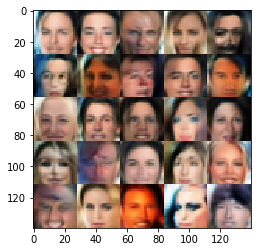

Epoch 1/1... Generator Loss: 2.3015 Discriminator Loss: 0.8451...
Epoch 1/1... Generator Loss: 1.6633 Discriminator Loss: 0.7272...
Epoch 1/1... Generator Loss: 2.0805 Discriminator Loss: 0.6653...
Epoch 1/1... Generator Loss: 2.5023 Discriminator Loss: 0.6546...
Epoch 1/1... Generator Loss: 2.3737 Discriminator Loss: 0.8260...
Epoch 1/1... Generator Loss: 1.3736 Discriminator Loss: 0.8742...
Epoch 1/1... Generator Loss: 2.0813 Discriminator Loss: 0.8728...
Epoch 1/1... Generator Loss: 1.4368 Discriminator Loss: 0.6136...
Epoch 1/1... Generator Loss: 1.2333 Discriminator Loss: 0.9823...
Epoch 1/1... Generator Loss: 2.0228 Discriminator Loss: 0.8065...


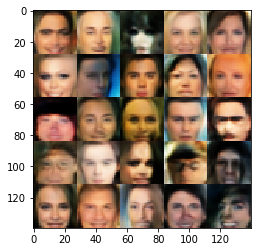

Epoch 1/1... Generator Loss: 2.1387 Discriminator Loss: 0.7466...
Epoch 1/1... Generator Loss: 1.7336 Discriminator Loss: 0.7907...
Epoch 1/1... Generator Loss: 1.1013 Discriminator Loss: 0.7306...
Epoch 1/1... Generator Loss: 1.1480 Discriminator Loss: 0.7741...
Epoch 1/1... Generator Loss: 1.5368 Discriminator Loss: 0.9354...
Epoch 1/1... Generator Loss: 2.3348 Discriminator Loss: 0.6915...
Epoch 1/1... Generator Loss: 1.5554 Discriminator Loss: 0.7807...
Epoch 1/1... Generator Loss: 2.8715 Discriminator Loss: 0.7902...
Epoch 1/1... Generator Loss: 2.7694 Discriminator Loss: 0.6392...
Epoch 1/1... Generator Loss: 1.0432 Discriminator Loss: 0.9735...


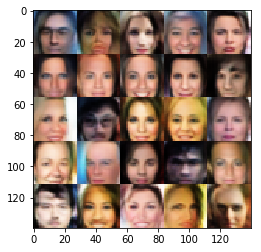

Epoch 1/1... Generator Loss: 1.5173 Discriminator Loss: 0.7742...
Epoch 1/1... Generator Loss: 1.3734 Discriminator Loss: 0.8032...
Epoch 1/1... Generator Loss: 1.7288 Discriminator Loss: 0.9068...
Epoch 1/1... Generator Loss: 1.4926 Discriminator Loss: 0.8507...
Epoch 1/1... Generator Loss: 1.8955 Discriminator Loss: 0.8140...
Epoch 1/1... Generator Loss: 2.4353 Discriminator Loss: 1.0107...
Epoch 1/1... Generator Loss: 2.3439 Discriminator Loss: 0.7207...
Epoch 1/1... Generator Loss: 2.4320 Discriminator Loss: 0.5115...
Epoch 1/1... Generator Loss: 1.2522 Discriminator Loss: 0.8548...
Epoch 1/1... Generator Loss: 1.5534 Discriminator Loss: 0.7368...


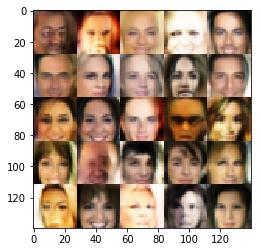

Epoch 1/1... Generator Loss: 1.6687 Discriminator Loss: 0.6768...
Epoch 1/1... Generator Loss: 1.0021 Discriminator Loss: 0.8325...
Epoch 1/1... Generator Loss: 1.4410 Discriminator Loss: 0.8142...
Epoch 1/1... Generator Loss: 1.9300 Discriminator Loss: 0.7435...
Epoch 1/1... Generator Loss: 1.7708 Discriminator Loss: 0.7043...
Epoch 1/1... Generator Loss: 2.2339 Discriminator Loss: 0.4955...
Epoch 1/1... Generator Loss: 1.5069 Discriminator Loss: 0.7905...
Epoch 1/1... Generator Loss: 1.9120 Discriminator Loss: 0.6370...
Epoch 1/1... Generator Loss: 1.5761 Discriminator Loss: 0.7334...
Epoch 1/1... Generator Loss: 1.6511 Discriminator Loss: 0.6700...


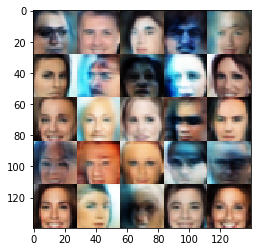

Epoch 1/1... Generator Loss: 1.6737 Discriminator Loss: 0.6775...
Epoch 1/1... Generator Loss: 2.0752 Discriminator Loss: 0.7917...
Epoch 1/1... Generator Loss: 2.7354 Discriminator Loss: 0.7087...
Epoch 1/1... Generator Loss: 2.5673 Discriminator Loss: 0.7325...
Epoch 1/1... Generator Loss: 1.5124 Discriminator Loss: 0.6977...
Epoch 1/1... Generator Loss: 1.3678 Discriminator Loss: 0.8867...
Epoch 1/1... Generator Loss: 2.1018 Discriminator Loss: 0.9289...
Epoch 1/1... Generator Loss: 1.8439 Discriminator Loss: 0.8984...
Epoch 1/1... Generator Loss: 2.6158 Discriminator Loss: 0.9703...
Epoch 1/1... Generator Loss: 1.4699 Discriminator Loss: 0.9117...


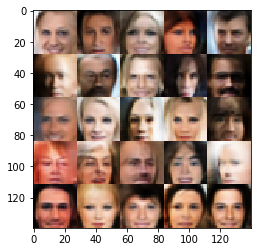

Epoch 1/1... Generator Loss: 1.5267 Discriminator Loss: 0.6878...
Epoch 1/1... Generator Loss: 1.8622 Discriminator Loss: 0.8523...
Epoch 1/1... Generator Loss: 1.6539 Discriminator Loss: 0.7009...
Epoch 1/1... Generator Loss: 2.4803 Discriminator Loss: 0.6492...
Epoch 1/1... Generator Loss: 1.7834 Discriminator Loss: 0.8957...
Epoch 1/1... Generator Loss: 1.5152 Discriminator Loss: 0.9931...
Epoch 1/1... Generator Loss: 2.0278 Discriminator Loss: 0.6268...
Epoch 1/1... Generator Loss: 1.8857 Discriminator Loss: 0.8870...
Epoch 1/1... Generator Loss: 1.6472 Discriminator Loss: 0.8479...
Epoch 1/1... Generator Loss: 3.0734 Discriminator Loss: 0.6824...


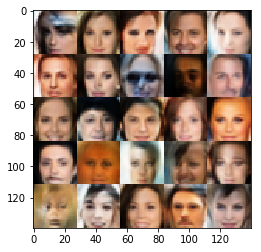

Epoch 1/1... Generator Loss: 1.8599 Discriminator Loss: 0.6095...
Epoch 1/1... Generator Loss: 1.9853 Discriminator Loss: 0.6078...
Epoch 1/1... Generator Loss: 1.8970 Discriminator Loss: 0.9886...
Epoch 1/1... Generator Loss: 2.8133 Discriminator Loss: 0.6251...
Epoch 1/1... Generator Loss: 2.2111 Discriminator Loss: 0.6326...
Epoch 1/1... Generator Loss: 2.0689 Discriminator Loss: 0.6406...
Epoch 1/1... Generator Loss: 2.1787 Discriminator Loss: 0.8527...
Epoch 1/1... Generator Loss: 1.1995 Discriminator Loss: 0.8062...
Epoch 1/1... Generator Loss: 1.8228 Discriminator Loss: 0.9357...
Epoch 1/1... Generator Loss: 1.9001 Discriminator Loss: 0.8104...


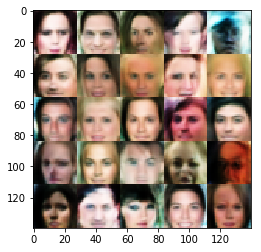

Epoch 1/1... Generator Loss: 2.4706 Discriminator Loss: 0.7571...
Epoch 1/1... Generator Loss: 2.2134 Discriminator Loss: 0.6460...
Epoch 1/1... Generator Loss: 1.1066 Discriminator Loss: 1.0558...
Epoch 1/1... Generator Loss: 2.2621 Discriminator Loss: 0.7531...
Epoch 1/1... Generator Loss: 2.6904 Discriminator Loss: 0.6093...
Epoch 1/1... Generator Loss: 1.5853 Discriminator Loss: 0.8299...
Epoch 1/1... Generator Loss: 0.9542 Discriminator Loss: 1.0616...
Epoch 1/1... Generator Loss: 1.7689 Discriminator Loss: 0.6368...
Epoch 1/1... Generator Loss: 3.1869 Discriminator Loss: 0.5678...
Epoch 1/1... Generator Loss: 1.8350 Discriminator Loss: 0.7608...


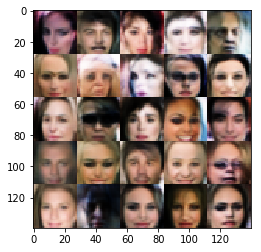

Epoch 1/1... Generator Loss: 1.9831 Discriminator Loss: 0.7936...
Epoch 1/1... Generator Loss: 2.3380 Discriminator Loss: 0.5391...
Epoch 1/1... Generator Loss: 2.2079 Discriminator Loss: 0.9998...
Epoch 1/1... Generator Loss: 2.7136 Discriminator Loss: 0.7419...
Epoch 1/1... Generator Loss: 1.4557 Discriminator Loss: 0.9632...
Epoch 1/1... Generator Loss: 1.5216 Discriminator Loss: 0.7038...
Epoch 1/1... Generator Loss: 1.9001 Discriminator Loss: 0.9281...
Epoch 1/1... Generator Loss: 1.4341 Discriminator Loss: 1.0148...
Epoch 1/1... Generator Loss: 1.5255 Discriminator Loss: 0.6261...
Epoch 1/1... Generator Loss: 1.7685 Discriminator Loss: 0.7604...


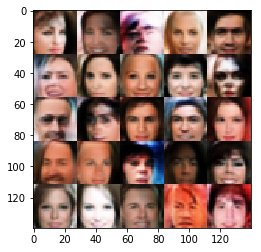

Epoch 1/1... Generator Loss: 1.5685 Discriminator Loss: 0.8367...
Epoch 1/1... Generator Loss: 1.6256 Discriminator Loss: 0.7301...
Epoch 1/1... Generator Loss: 1.9310 Discriminator Loss: 0.6380...


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.